In [203]:
import string

import sqlite3
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from gensim.models import ldamodel, lsimodel
from IPython.display import display
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option("display.max_columns", 9999)

# TODO: topic models
# TODO: other nlp stuff like parse trees, tfidf + cosine scores, etc
# word embeddings?
# semantic analysis, what is said about different persons/countries

In [73]:
# Establish a database connection
db_conn = sqlite3.connect("/home/john/datasets/hillary-emails/database.sqlite")
db = db_conn.cursor()
pd_sql = lambda query, params=None: pd.read_sql_query(query, params=params, con=db_conn)

First let's see how the database is structured.

In [85]:
tables = pd_sql("SELECT tbl_name FROM sqlite_master WHERE type='table'")
display(tables)

for _, t in tables.iterrows():
    display(t.tbl_name)
    t_info = pd_sql("PRAGMA table_info({})".format(t.tbl_name))
    display(pd.DataFrame(columns=t_info["name"]))

,tbl_name
0,Emails
1,Persons
2,Aliases
3,EmailReceivers


'Emails'

name,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,ExtractedSubject,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText


'Persons'

name,Id,Name


'Aliases'

name,Id,Alias,PersonId


'EmailReceivers'

name,Id,EmailId,PersonId


## Email body texts
Let's start the exploration by looking at the email bodies.

In [174]:
email_bodies = pd_sql("SELECT ExtractedBodyText FROM Emails WHERE ExtractedBodyText != ''")
display(email_bodies.sample(10))
email_bodies = pd.Series(email_bodies.ExtractedBodyText)

,ExtractedBodyText
842,Scott--\nI think this is an idea worth explori...
6197,I thought prox talks started.
1029,Ok.
1141,Dear Tom--\nH <hrod17@clintonemail.com>\nFrida...
1830,"Mills, Cheryl D <MillsCD@state.gov>\nSunday, J..."
4830,Makes sense. We'll get it done. Presume you wa...
4592,W I'll send you details later\nSent from my iP...
74,"H <hrod17@clintonernail.com>\nFriday, April 8,..."
319,Ok
1031,I agree. Thx.


## Email lengths

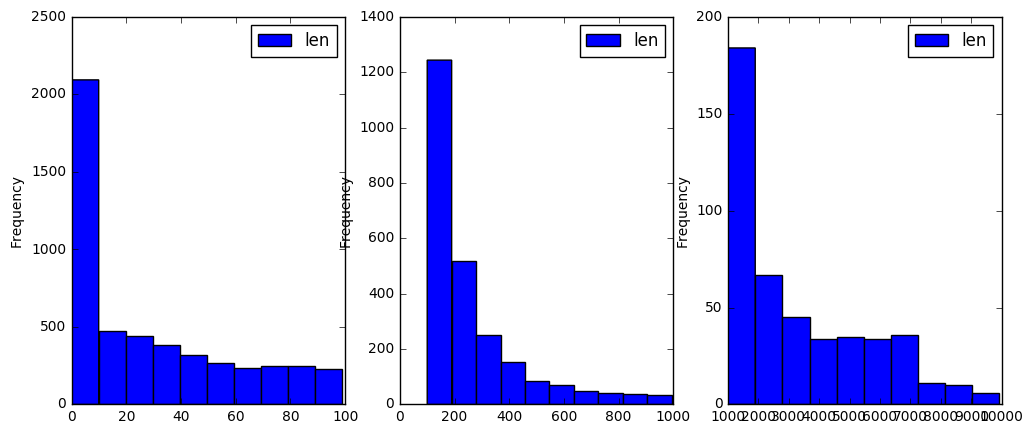

In [170]:
email_body_lengths = pd_sql("SELECT length(ExtractedBodyText) as len FROM Emails")

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
condition = lambda above, below: (above <= email_body_lengths.len) & (email_body_lengths.len < below)
email_body_lengths.loc[condition(0, 100)].plot.hist(bins=10, ax=ax1)
email_body_lengths.loc[condition(100, 1000)].plot.hist(bins=10, ax=ax2)
email_body_lengths.loc[condition(1000, 10000)].plot.hist(bins=10, ax=ax3)

## Data cleaning

In [201]:
nltk.download("punkt")
nltk.download("stopwords")
stop_words = stopwords.words("english")

def clean(s):
    # TODO: should maybe parse timestamps, dates etc into one token?
    tokens = nltk.word_tokenize(s.lower())
    return [t for t in tokens if t not in string.punctuation and t not in stop_words]

email_bodies_cleaned = email_bodies.apply(clean)

[nltk_data] Downloading package punkt to /home/john/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/john/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Topic modeling
Topic models are statistical model that try to find structure in text corpuses by finding "topics". A topic defines a distribution over the vocabulary of the whole corpus.


In [ ]:
# Prepare corpus
